Import all necessary modules and check GPU.

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pydot
from tensorflow.keras.utils import plot_model
import pc  # custom module

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Check CUDA support
if len(tf.config.list_physical_devices("GPU")) > 0:
    print("CUDA enabled.")
else:
    print("CUDA not enabled.")

# Enable automatic mixed precision (not compatible with my GPU GeForce GTX 1060 6GB)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

CUDA enabled.


Set folder with dataset, number of epochs, batch size, resolution and seed.

In [2]:
# Path to dataset
data_folder = "./nuovo_dataset"
#"/app/data/PokemonData"
# Training parameters
EP = 100
BS = 64
# Image resolution
RES = (224, 224)
# Random seed
SEED = 69

Create dataset with specified parameters.

In [3]:
data_dict = pc.create_dataset(
    data_folder,
    epochs=EP,
    batch_size=BS,
    res=RES,
    seed=SEED,
)

Split dataset into train, validation and test set.

In [4]:
train_dataset = data_dict["train_dataset"]
val_dataset = data_dict["val_dataset"]
test_dataset = data_dict["test_dataset"]
train_len = data_dict["train_len"]
val_len = data_dict["val_len"]
test_len = data_dict["test_len"]

Get length of train, validation and test set. Print them. Get LabelEncoder classes.

In [5]:
label_encoder = data_dict["label_encoder"]
# print(list(label_encoder.classes_))
#np.save('best_classes.npy', label_encoder.classes_)
print(f"Number of training samples: {train_len}")
print(f"Number of validation samples: {val_len}")
print(f"Number of test samples: {test_len}")

Number of training samples: 6738
Number of validation samples: 750
Number of test samples: 750


Associate image to label encoder. Show 8 samples from train set.

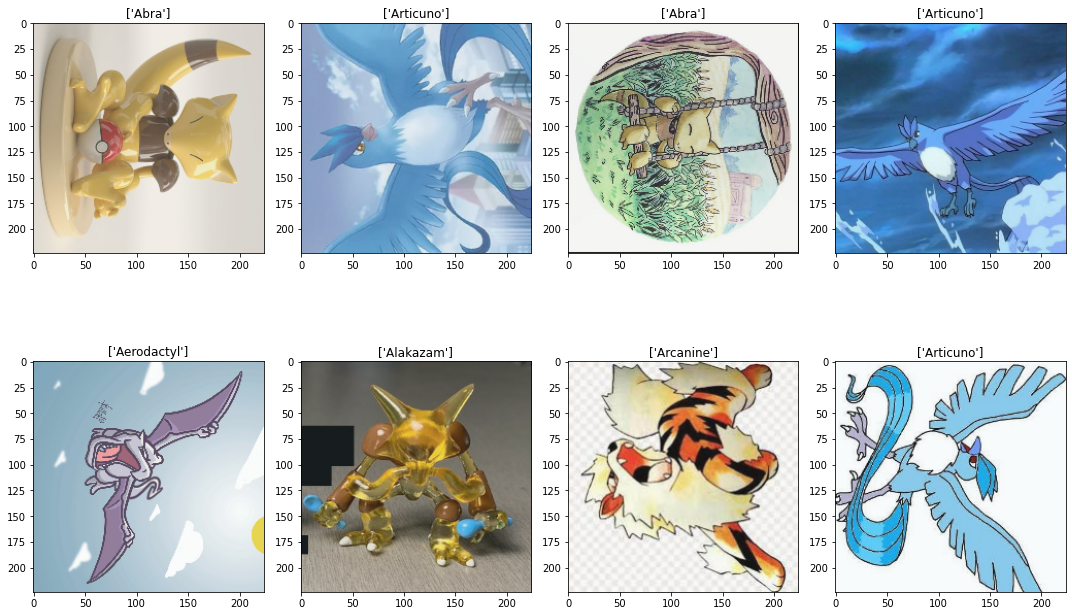

In [6]:
plt.figure(figsize=(15, 10))

# Iterate over batches
for (image_batch, label_batch) in train_dataset:
    # Iterate over elements in batch
    for i, (image, label) in enumerate(zip(image_batch[:8], label_batch[:8])):
        plt.subplot(2, 4, i + 1)
        plt.title(label_encoder.inverse_transform([label]))
        plt.imshow((255 * image.numpy()).astype(np.uint8))
    break

plt.tight_layout()
plt.show()

My CNN model.

Model: "Pokemon-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32

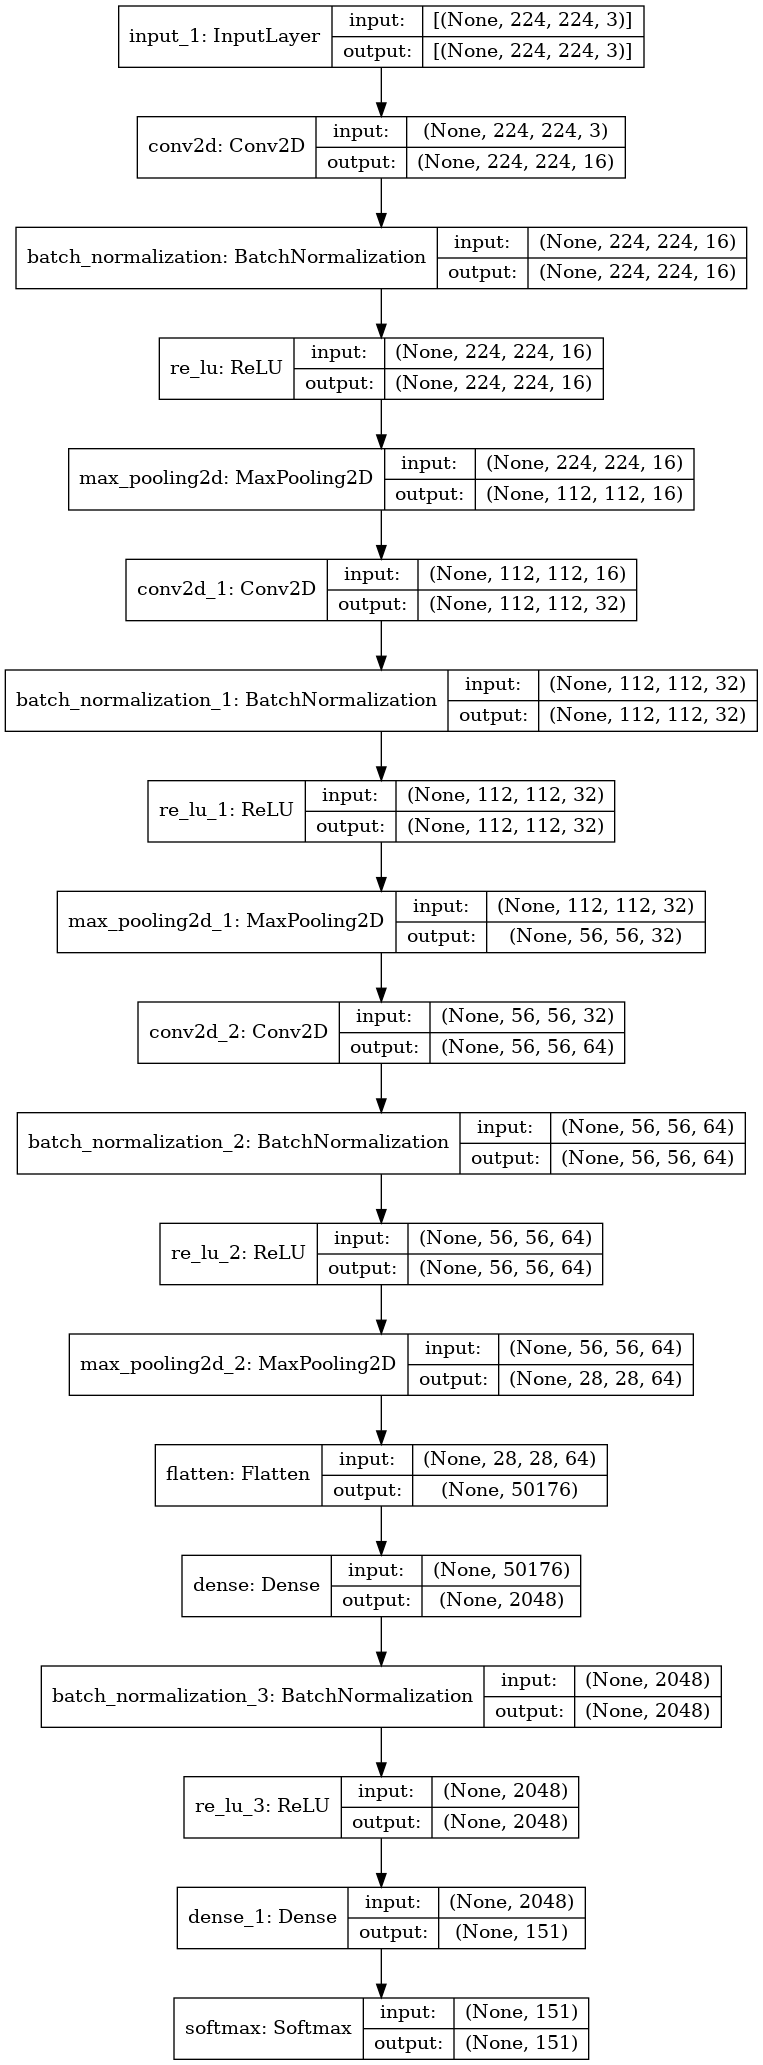

In [7]:
model = pc.create_model(n_conv=3, use_bn=True, res=RES)
model.summary()
plot_model(model, show_shapes=True)

Compile and train model.

In [8]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), #from_logits=True
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=EP,
    callbacks=[callback],
    steps_per_epoch=train_len // BS,
    validation_data=val_dataset,
    validation_steps=val_len // BS
)

Epoch 1/100
105/105 [==============================] - 16s 130ms/step - loss: 8.7179 - accuracy: 0.0320 - val_loss: 6.1200 - val_accuracy: 0.0000e+00
Epoch 2/100
105/105 [==============================] - 13s 127ms/step - loss: 6.5840 - accuracy: 0.0210 - val_loss: 5.5030 - val_accuracy: 0.0241
Epoch 3/100
105/105 [==============================] - 14s 131ms/step - loss: 5.8901 - accuracy: 0.0277 - val_loss: 5.0201 - val_accuracy: 0.0369
Epoch 4/100
105/105 [==============================] - 14s 130ms/step - loss: 5.3974 - accuracy: 0.0327 - val_loss: 5.2807 - val_accuracy: 0.0497
Epoch 5/100
105/105 [==============================] - 14s 130ms/step - loss: 4.9824 - accuracy: 0.0391 - val_loss: 4.7542 - val_accuracy: 0.0668
Epoch 6/100
105/105 [==============================] - 14s 130ms/step - loss: 4.6689 - accuracy: 0.0467 - val_loss: 4.3071 - val_accuracy: 0.0952
Epoch 7/100
105/105 [==============================] - 14s 130ms/step - loss: 4.4032 - accuracy: 0.0659 - val_loss: 4.27

Epoch 57/100
105/105 [==============================] - 14s 131ms/step - loss: 0.0957 - accuracy: 0.9805 - val_loss: 0.1620 - val_accuracy: 0.9489
Epoch 58/100
105/105 [==============================] - 14s 132ms/step - loss: 0.1000 - accuracy: 0.9769 - val_loss: 0.1106 - val_accuracy: 0.9645
Epoch 59/100
105/105 [==============================] - 14s 130ms/step - loss: 0.0905 - accuracy: 0.9792 - val_loss: 0.1630 - val_accuracy: 0.9560
Epoch 60/100
105/105 [==============================] - 14s 131ms/step - loss: 0.0815 - accuracy: 0.9847 - val_loss: 0.1604 - val_accuracy: 0.9531
Epoch 61/100
105/105 [==============================] - 14s 132ms/step - loss: 0.0788 - accuracy: 0.9825 - val_loss: 0.0796 - val_accuracy: 0.9759
Epoch 62/100
105/105 [==============================] - 14s 131ms/step - loss: 0.0768 - accuracy: 0.9838 - val_loss: 0.1829 - val_accuracy: 0.9460
Epoch 63/100
105/105 [==============================] - 14s 130ms/step - loss: 0.0763 - accuracy: 0.9847 - val_loss: 0

In [ ]:
# Save model (tensorflow standard format)
model.save("vecchio_dataset_55fotoclasse_hue")

In [9]:
test_dict = model.evaluate(
    test_dataset,
    steps=test_len,
    return_dict=True
)

750/750 [==============================] - 3s 5ms/step - loss: 0.0262 - accuracy: 0.9933


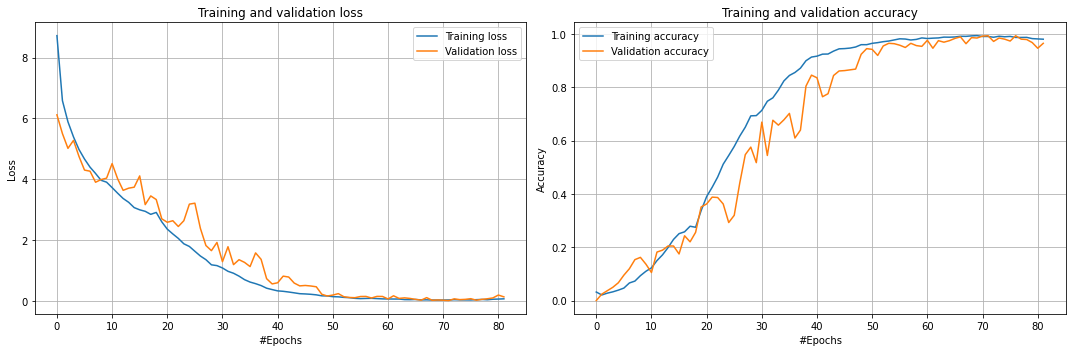

In [11]:
plt.figure(figsize=(15, 5))  # set graph dimension

# 1. First graph

plt.subplot(1, 2, 1)  # creates 1 subplot out of 2

plt.title("Training and validation loss")
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Loss")
plt.grid()

# 2. Second Graph

plt.subplot(1, 2, 2)  # creates 1 subplot out of 2

plt.title("Training and validation accuracy")
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

In [10]:
import tensorflow as tf
import os
#model = tf.keras.models.load_model("./new_model_spero_fighissimo")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()#save converted quantization model to tflite format
open("vecchio_dataset_55fotoclasse_hue.tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpd_rorr28/assets


103110864

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
from matplotlib import pyplot as plt

img = load_img("./images/pika.jpg", target_size=(224, 224))
plt.imshow(img)
img = img_to_array(img, dtype=np.float32)
img /= 255
img = np.expand_dims(img, axis=0)
score = pc.top_k_predictions(model, img, label_encoder)
print(score)

Get all train, validation, and test labels. Plot 3 graphs with the number of each Pokémon for train, validation and test set.

In [ ]:
train_labels = {
    label_encoder.inverse_transform([i])[0]: 0
    for i in range(151)
}
train_it = iter(train_dataset)
for i in range(train_len // BS):
    (_, label_batch) = next(train_it)
    for label in label_batch:
        label_name = label_encoder.inverse_transform([label])[0]
        train_labels[label_name] += 1
print("Training: done")

val_labels = {
    label_encoder.inverse_transform([i])[0]: 0
    for i in range(151)
}
val_it = iter(val_dataset)
for i in range(val_len // BS):
    (_, label_batch) = next(val_it)
    for label in label_batch:
        label_name = label_encoder.inverse_transform([label])[0]
        val_labels[label_name] += 1
print("Validation: done")
        
#val_labels = [0 for _ in range(151)]
#val_it = iter(val_dataset)
#for i in range(val_len // BS):
#    (_, label_batch) = next(val_it)
#    for label in label_batch:
#        val_labels[label.numpy()] +=1
#print("Validation: done")

test_labels = {
    label_encoder.inverse_transform([i])[0]: 0
    for i in range(151)
}
#test_labels = [0 for _ in range(151)]
test_it = iter(test_dataset)
for i, (_, label) in enumerate(test_it):
    label_name = label_encoder.inverse_transform([label])[0]
    test_labels[label_name] += 1
    #test_labels[label.numpy()[0]]+=1
print("Test: done")

plt.figure(figsize=(10, 40))

plt.title("Training classes")
plt.barh(list(train_labels.keys()), train_labels.values())

plt.figure(figsize=(10, 40))
plt.title("Validation classes")
plt.barh(list(val_labels.keys()), val_labels.values())

plt.figure(figsize=(10, 40))
plt.title("Test classes")
plt.barh(list(test_labels.keys()), test_labels.values())
plt.show()

# plt.figure(figsize=(15, 10))
# plt.subplot(3, 1, 1)
# plt.plot(train_labels)
# plt.title("Training classes")
# plt.subplot(3, 1, 2)
# plt.plot(val_labels)
# plt.title("Validation classes")
# plt.subplot(3, 1, 3)
# plt.plot(test_labels)
# plt.title("Test classes")
# plt.tight_layout()
# plt.show()
